#**Tarea : Etapa 3. Adecuación y validación del Modelo**

#**Equipo 1:**

##**Rogelio Coria López | A01733314**

##**Adrián Mateos Garza | A01722496**

##**Antonio Pena Lozano | A01722688**

##**Alfonso Elizondo Partida | A01285151**

In [1]:
import pandas as pd

In [2]:
df_edenred=pd.read_excel('data/df_21_24_clean.xlsx')

In [8]:
df_edenred.head(1)

,Unnamed: 0,Year,Month,Id Región,Cliente,Division,BL,Mercancía,RecorridoNegativos,Recorrido,...,Cantidad Mercancía,KG C02,Arboles,Precio Unitario,Rendimiento,Rendimiento Real,Vehículo,Conductor,Identificador Vehículo,Vehículo_Corto
0,0,2023,1,1000,02125-031,DAI,IGWC,G SUPER,144,144,...,49.784626,120.528579,8.035239,22.502578,14.0,4.11,Unidad 1FTMF1E57JKC06402,BENICE IXCHETL RODRIGUEZ VIVANCO,1E57JKC06402,1FTMF1E57JK


In [ ]:
categorical_cols = ['Id Región', 'Cliente', 'Division', 'BL', 'Mercancía', 'Vehículo_Corto']

In [21]:
'''df_edenred['Id Región'].value_counts()
df_edenred['Cliente'].value_counts()
df_edenred['Division'].value_counts()
df_edenred['BL'].value_counts()
df_edenred['Mercancía'].value_counts()'''

print("Número de valores únicos por columna:")
print(df_edenred['Id Región'].nunique())
print(df_edenred['Cliente'].nunique())
print(df_edenred['Division'].nunique())
print(df_edenred['BL'].nunique())
print(df_edenred['Mercancía'].nunique())
print(df_edenred['Vehículo'].nunique())

Número de valores únicos por columna:
27
10
5
19
11
446


In [24]:
df_edenred = pd.read_excel('data/df_21_24_clean.xlsx')
print(df_edenred.shape)
print(df_edenred['Vehículo'].nunique())
# Filtrar vehículos que aparecen más de 2 veces
vehiculo_counts = df_edenred['Vehículo'].value_counts()
vehiculos_frecuentes = vehiculo_counts[vehiculo_counts > 10].index
df_edenred = df_edenred[df_edenred['Vehículo'].isin(vehiculos_frecuentes)]

(36353, 21)
671


In [23]:
print(df_edenred['Vehículo'].nunique())
print(df_edenred.shape)

353
(35197, 21)


#**Revisión de estructura de datos**
##Revisamos la estructura del DataFrame para conocer el número de observaciones, columnas, tipos de datos y presencia de valores nulos.

In [ ]:
df_edenred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36353 entries, 0 to 36352
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              36353 non-null  int64  
 1   Year                    36353 non-null  int64  
 2   Month                   36353 non-null  int64  
 3   Id Región               36353 non-null  object 
 4   Cliente                 36353 non-null  object 
 5   Division                36353 non-null  object 
 6   BL                      36353 non-null  object 
 7   Mercancía               36353 non-null  object 
 8   RecorridoNegativos      36353 non-null  int64  
 9   Recorrido               36353 non-null  int64  
 10  Importe Transacción     36353 non-null  float64
 11  Cantidad Mercancía      36353 non-null  float64
 12  KG C02                  36353 non-null  float64
 13  Arboles                 36353 non-null  float64
 14  Precio Unitario         36353 non-null

#**Cálculo de emisión de CO2 por kilómetro**
##Se añade una nueva variable que representa la eficiencia ambiental, dividiendo las emisiones de CO2 entre la distancia recorrida por cada transacción.



In [ ]:
df_edenred['KG C02 por Recorrido']=df_edenred['KG C02']/df_edenred['Recorrido']

##**Construcción de Mapper sobre variables categóricas**

##Se implementa el algoritmo Mapper para generar un resumen topológico de las variables categóricas del dataset. Primero se codifican con OneHotEncoder, luego se proyectan a 2 dimensiones usando PCA. Finalmente, se construye una red Mapper utilizando DBSCAN y se visualiza como archivo HTML.

In [ ]:
import pandas as pd
import numpy as np

#Instalaciones necesarias:
#pip install kmapper scikit-learn matplotlib

import kmapper as km
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

#Preparar solo las columnas categóricas
categorical_cols = [
    'Id Región',
    'Cliente',
    'Division',
    'BL',
    'Mercancía',
    'Conductor',
    'Vehículo_Corto'
]

#Asegurar que no haya valores nulos en las columnas categóricas
df_edenred[categorical_cols] = df_edenred[categorical_cols].fillna('NULO')

#Convertir cada categoría a string (por si hay ints mezclados):
for c in categorical_cols:
    df_edenred[c] = df_edenred[c].astype(str)

#Transformar las categóricas en un arreglo numérico para Mapper
#Se utiliza OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_cat_ohe = ohe.fit_transform(df_edenred[categorical_cols])

#Elegir un “lens” (lente) para Mapper
#Por simplicidad se toman los primeros 2 componentes PCA de la matriz one-hot.
pca = PCA(n_components=2, random_state=42)
lens = pca.fit_transform(X_cat_ohe)

#Configurar KeplerMapper y construir el grafo
mapper = km.KeplerMapper(verbose=1)

#“cover” controla en cuántos intervalos rebanamos cada dimensión y cuánto se solapan
coverer = km.Cover(n_cubes=5, perc_overlap=0.5)

# Usamos DBSCAN sobre el espacio one-hot para agrupar puntos en cada intervalo
clusterer = DBSCAN(eps=2.5, min_samples=100)
color_array = df_edenred['Rendimiento Real'].values

# Construimos el grafo topológico sobre el espacio categórico transformado:
graph = mapper.map(
    lens,          # las coordenadas 2D que usamos como “lente”
    X_cat_ohe,     # los datos (la matriz one-hot) sobre los que clusterizamos
    cover=coverer,
    clusterer=clusterer
)
tooltips_array = df_edenred.index.astype(str).values
# Después de haber construido `graph`:
mapper.visualize(
    graph,
    path_html="edenred_mapper.html",  # nombre del archivo de salida
    title="Mapper sobre categorías de Edenred",
    color_values=color_array,
    color_function_name=["Rendimiento Real"],
    custom_tooltips=tooltips_array  # opcional: mostrar índices como tooltips
)


KeplerMapper(verbose=1)
Mapping on data shaped (36353, 1213) using lens shaped (36353, 2)

Creating 25 hypercubes.

Created 47 edges and 23 nodes in 0:00:36.142343.
Wrote visualization to: edenred_mapper.html


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Mapper sobre categorías de Edenred | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size

##**Asignación de clústers desde Mapper**
##Después de construir el grafo Mapper, se asigna un identificador de clúster a cada observación del dataset. Estas etiquetas permitirán evaluar si existen diferencias sistemáticas en el rendimiento del vehículo asociadas a agrupamientos topológicos.

In [ ]:
import numpy as np

n_samples = X_cat_ohe.shape[0]
mapper_cluster = np.full(shape=n_samples, fill_value=-1, dtype=int)

# Recorremos cada nodo y le damos un ID incremental (0, 1, 2, …)
for new_cluster_id, node_id_str in enumerate(graph["nodes"].keys()):
    # graph["nodes"][node_id_str] es la lista de índices de filas que pertenecen a ese nodo
    for idx in graph["nodes"][node_id_str]:
        if mapper_cluster[idx] == -1:
            mapper_cluster[idx] = new_cluster_id

# Si quedara algún -1 (es decir, filas que no entraron en ningún cluster),
# las re-asignamos al siguiente ID:
unassigned = np.where(mapper_cluster == -1)[0]
if len(unassigned) > 0:
    next_id = mapper_cluster.max() + 1
    mapper_cluster[unassigned] = next_id

# Ahora `mapper_cluster` es un vector de longitud n_samples,
# donde cada posición contiene el número de cluster (0,1,2,…) de esa fila.
n_clusters = mapper_cluster.max() + 1
print(f"Mapper produjo {n_clusters} clusters en total.")

# Finalmente, se agrega al DataFrame original:
df_edenred["mapper_cluster"] = mapper_cluster


Mapper produjo 22 clusters en total.


##**Modelo de regresión usando clusters Mapper**
##Se entrena un modelo de regresión RandomForest para predecir el rendimiento real del vehículo. Se incluyen variables numéricas y la agrupación Mapper como variable categórica. La evaluación se realiza sobre los últimos cinco meses disponibles.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

y = df_edenred['Rendimiento Real']
#Descartamos las categóricas originales
X=df_edenred[['Recorrido','Cantidad Mercancía', 'mapper_cluster']]

#Convertir mapper_cluster a string para OneHot
X['mapper_cluster'] = df_edenred['mapper_cluster'].astype(str)

#Definir numéricas y la nueva categórica única
columnas_numericas = [
    'Recorrido', 'Cantidad Mercancía'
]
columnas_categoricas = ['mapper_cluster']

#ColumnTransformer mucho más pequeño:
preprocesamiento = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), columnas_categoricas)
    ],
    remainder='drop'
)

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

modelo = RandomForestRegressor(n_estimators=100, random_state=42)
pipeline = Pipeline([
    ('preproc', preprocesamiento),
    ('regresor', modelo)
])

#Separar último mes vs el resto
df_edenred['YearMonth'] = df_edenred['Year'] * 100 + df_edenred['Month']

#Se obtiene la lista de YearMonth únicos ordenados
meses_unicos = sorted(df_edenred['YearMonth'].unique())

ultimos_5_meses = meses_unicos[-5:]

#Crear las máscaras de entrenamiento vs prueba:
#Entrenamiento: todos los meses anteriores al primero de esos últimos 5
#Prueba: cualquier fila cuyo YearMonth esté en esa lista de 5 meses
min_ultimo_5 = ultimos_5_meses[0]

train_mask = df_edenred['YearMonth'] < min_ultimo_5
test_mask  = df_edenred['YearMonth'].isin(ultimos_5_meses)

X_train = X[train_mask]
X_test  = X[test_mask]
y_train = y[train_mask]
y_test  = y[test_mask]


#Entrenamiento y Prediccón
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"RMSE (último mes): {rmse:.3f}")
print(f"R²   (último mes): {r2:.3f}")
print(f"MAE  (último mes): {mae:.3f}")
print(f"MAPE (último mes): {mape:.3%}")


C:\Users\rogel\AppData\Local\Temp\ipykernel_17612\3808017416.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['mapper_cluster'] = df_edenred['mapper_cluster'].astype(str)


RMSE (último mes): 0.655
R²   (último mes): 0.955
MAE  (último mes): 0.425
MAPE (último mes): 7.475%


D:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##**Visualización de resultados del modelo**
##Se generan dos visualizaciones. Un gráfico de dispersión que compara valores predichos contra reales. Una serie de tiempo para evaluar la evolución del rendimiento promedio mensual (predicho vs. real).

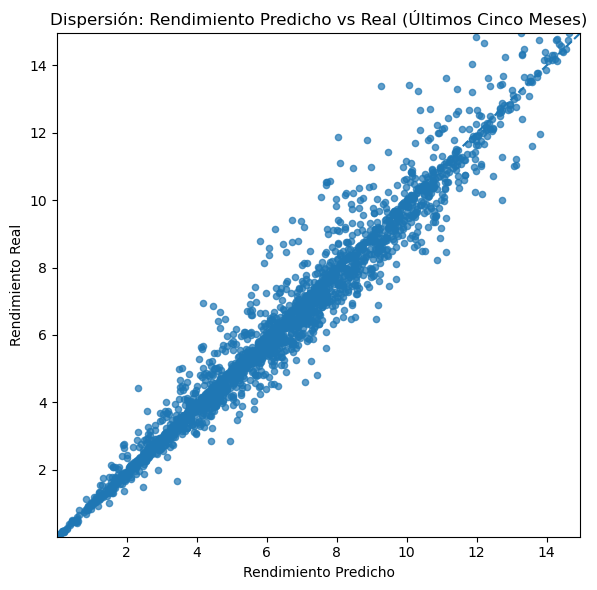

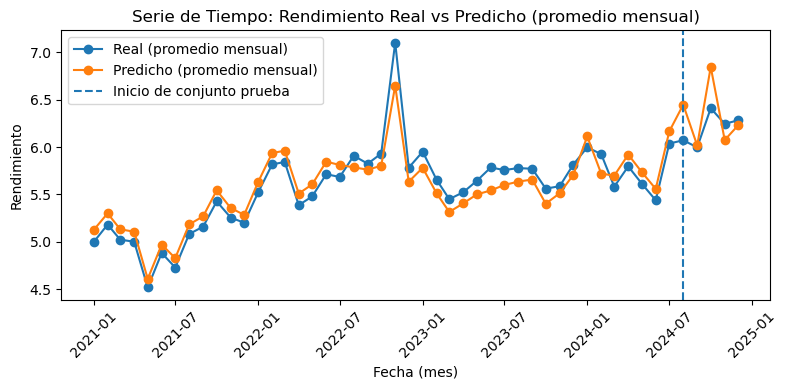

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

#Gráfico de Dispersión Predicho vs Real
# Creamos la figura y los ejes
fig, ax = plt.subplots(figsize=(6,6))

#Dibujamos los puntos (Predicho, Real)
ax.scatter(y_pred, y_test, s=20, alpha=0.7)

#Dibujamos la diagonal y = x
v_min = min(min(y_pred), min(y_test))
v_max = max(max(y_pred), max(y_test))
ax.plot([v_min, v_max], [v_min, v_max], linestyle='--')

ax.set_title('Dispersión: Rendimiento Predicho vs Real (Últimos Cinco Meses)')
ax.set_xlabel('Rendimiento Predicho')
ax.set_ylabel('Rendimiento Real')

# Ajustamos límites para que la diagonal cubra toda la nube
ax.set_xlim(v_min, v_max)
ax.set_ylim(v_min, v_max)

plt.tight_layout()
plt.show()



#Serie de Tiempo Promedio Mensual Predicho vs Real

#Reconstruimos una predicción para todo el dataset:
#Usamos pipeline.predict sobre todas las filas de X

X_full = X.copy()
y_real_full = df_edenred['Rendimiento Real']

# Convertimos mapper_cluster a str antes de preprocesar
X_full['mapper_cluster'] = X_full['mapper_cluster'].astype(str)

# Predecimos sobre todas las observaciones
y_pred_full = pipeline.predict(X_full)

#Montamos un DataFrame auxiliar para agrupar por mes:
df_aux = pd.DataFrame({
    'Year': df_edenred['Year'],
    'Month': df_edenred['Month'],
    'YearMonth': df_edenred['YearMonth'],
    'y_real': y_real_full,
    'y_pred': y_pred_full
})

#Convertimos YearMonth a fecha “primero de mes”, para graficar adecuadamente en el eje X:
df_aux['FechaMes'] = pd.to_datetime(df_aux['YearMonth'].astype(int).astype(str) + '01', format='%Y%m%d')

#Calculamos el promedio mensual de real y predicho:
df_prom = (
    df_aux
    .groupby('FechaMes')[['y_real','y_pred']]
    .mean()
    .reset_index()
    .sort_values('FechaMes')
)

#Identificamos el valor de FechaMes correspondiente al “último mes”:
ultimo_mes_num = min_ultimo_5
fecha_ultimo_mes = pd.to_datetime(str(int(ultimo_mes_num)) + '01', format='%Y%m%d')

#Gráfica de líneas
fig, ax = plt.subplots(figsize=(8,4))

# Línea de promedio real
ax.plot(df_prom['FechaMes'], df_prom['y_real'], marker='o', label='Real (promedio mensual)')
# Línea de promedio predicho
ax.plot(df_prom['FechaMes'], df_prom['y_pred'], marker='o', label='Predicho (promedio mensual)')

# Dibujamos una línea vertical para separar “entrenamiento” y “prueba”:
ax.axvline(fecha_ultimo_mes, linestyle='--', label='Inicio de conjunto prueba')

# Etiquetas en español
ax.set_title('Serie de Tiempo: Rendimiento Real vs Predicho (promedio mensual)')
ax.set_xlabel('Fecha (mes)')
ax.set_ylabel('Rendimiento')
ax.legend(loc='upper left')

# Formato de fechas en el eje X para que se lean bien
ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()
plt.show()


##**Conclusiones**

##La incorporación del análisis topológico mediante el algoritmo Mapper permitió identificar estructuras latentes dentro de las variables categóricas del conjunto de datos de Edenred. Estas estructuras fueron integradas como variables predictoras en un modelo de regresión Random Forest para estimar el rendimiento real de los vehículos.



##Los resultados cuantitativos son sólidos: el modelo alcanzó un coeficiente de determinación R^2 de 0.955, un MAE de 0.425 y un MAPE inferior al 7.5% en el conjunto de prueba (últimos cinco meses). Estas métricas sugieren que el modelo no solo predice con precisión, sino que mantiene un bajo margen de error incluso en valores absolutos.



##Las visualizaciones refuerzan esta conclusión. El gráfico de dispersión muestra una alineación cercana entre los rendimientos reales y los predichos, con la mayoría de los puntos ubicados cerca de la línea de identidad, lo que indica una baja varianza entre lo observado y lo estimado. Por otro lado, la serie de tiempo del rendimiento promedio mensual revela que el modelo capta adecuadamente las tendencias estacionales y las fluctuaciones del sistema, incluso después del punto de corte que separa entrenamiento y prueba.